In [120]:
# Import Modules
import os
import pandas as pd
import numpy as np
import edaTools as ET

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
from plotly.offline import init_notebook_mode
pio.renderers.default='notebook'
init_notebook_mode(connected = True)

In [121]:
## Load Data
master_file = ".\DataSource\Master_Details.csv"
master_df = pd.read_csv(master_file)
master_df.head()

,Date,Title,Address,City,State,Beds,Baths,Rent,SQFT
0,2/27/2019,Tacara Steiner Ranch,"4306 N Quinlan Park Rd,\r","Austin,",TX,1Bedroom,1Bathroom,"$1,041-5,000",624 Sq Ft
1,2/27/2019,Tacara Steiner Ranch,"4306 N Quinlan Park Rd,\r","Austin,",TX,1Bedroom,1Bathroom,"$1,219-5,000",825 Sq Ft
2,2/27/2019,Tacara Steiner Ranch,"4306 N Quinlan Park Rd,\r","Austin,",TX,1Bedroom,1Bathroom,"$1,380-5,000","1,125 Sq Ft"
3,2/27/2019,Tacara Steiner Ranch,"4306 N Quinlan Park Rd,\r","Austin,",TX,2BRs,2Bathrooms,"$1,418-5,000","1,139 Sq Ft"
4,2/27/2019,Tacara Steiner Ranch,"4306 N Quinlan Park Rd,\r","Austin,",TX,2BRs,2Bathrooms,"$1,773-5,000","1,299 Sq Ft"


In [122]:
## Format Columns
columns = master_df.columns
for column in columns:
    master_df[column] = ET.format_column(series=master_df[column], col=column)

In [123]:
## Add latitude and longitude to data
# Note: Computationally expensive; 1 sec per address
# Minimize impact by only looking at unique addresses

# Combine Address info into one column
geo_sr = master_df["Address"] + master_df["City"] + master_df["State"]
short_list = list(geo_sr.unique())
geo_sr = ET.get_latlong(short_list)
geo_sr["Address"] = geo_sr["Address"].str.replace("Austin,TX", "")
# Combine Lat and Long info back to df
master_df = pd.merge(master_df, geo_sr, on="Address", how="left")
master_df.head()

,Date,Title,Address,City,State,Beds,Baths,Rent,SQFT,latitude,longitude
0,Feb 19,Tacara Steiner Ranch,"4306 N Quinlan Park Rd,\r","Austin,",TX,1,1.0,1301.0,624.0,30.369441,-97.891081
1,Feb 19,Tacara Steiner Ranch,"4306 N Quinlan Park Rd,\r","Austin,",TX,1,1.0,1523.0,825.0,30.369441,-97.891081
2,Feb 19,Tacara Steiner Ranch,"4306 N Quinlan Park Rd,\r","Austin,",TX,1,1.0,1725.0,1125.0,30.369441,-97.891081
3,Feb 19,Tacara Steiner Ranch,"4306 N Quinlan Park Rd,\r","Austin,",TX,2,2.0,1772.0,1139.0,30.369441,-97.891081
4,Feb 19,Tacara Steiner Ranch,"4306 N Quinlan Park Rd,\r","Austin,",TX,2,2.0,2216.0,1299.0,30.369441,-97.891081


In [124]:
# Handle missing values (KNN imputer)
master_df = ET.fill_nan(master_df)


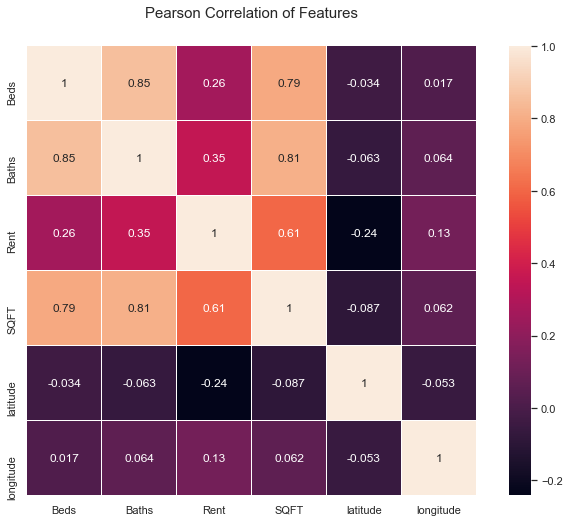

In [125]:
## Feature Heatmap
# In order to use linear regression, you need to check if there is correlation between the features

plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(master_df.corr(method='pearson'), linewidths=0.1, vmax=1.0,
            square=True, linecolor='white', annot=True)



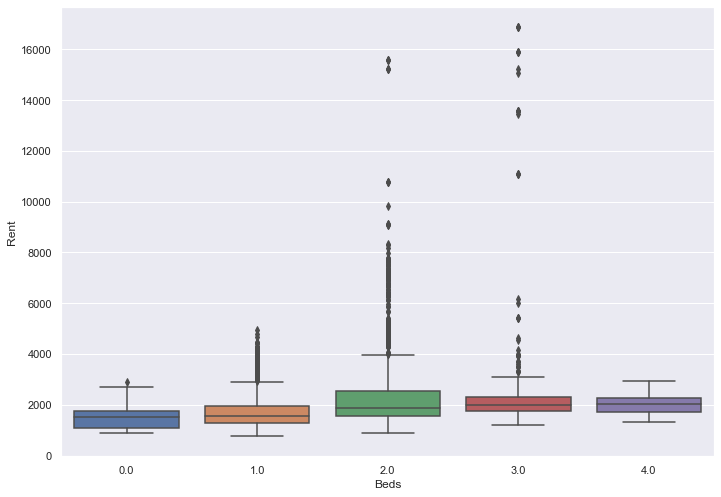

In [126]:
# Assumption: more bedrooms means higher rent
sb.boxplot(x=master_df["Beds"], y=master_df["Rent"])
plt.show()


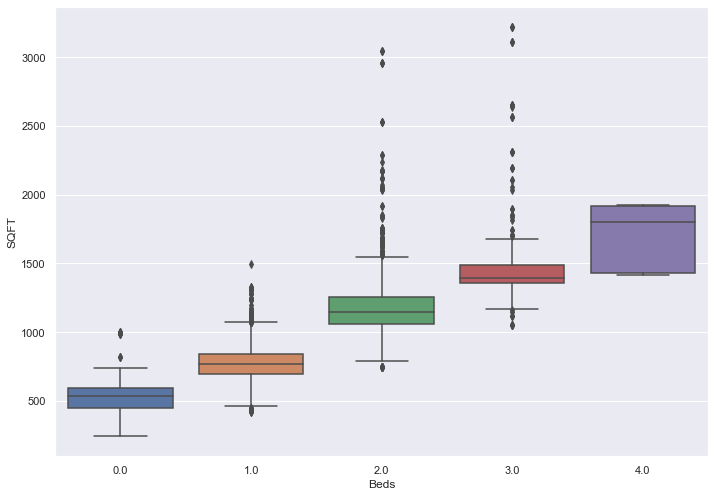

In [127]:
# Boxplot and Scatter comparing bedrooms and sqft
# Assumption: more bedrooms means more sqft
sb.boxplot(x="Beds", y="SQFT", data=master_df)
plt.show()


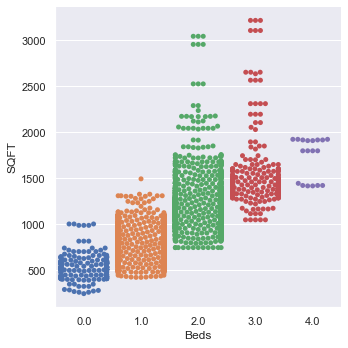

In [128]:

sb.catplot(x="Beds", y="SQFT",
            kind="swarm", data=master_df);

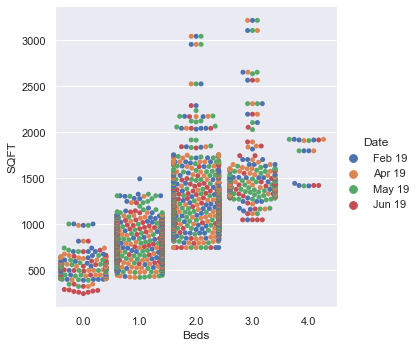

In [129]:

sb.catplot(x="Beds", y="SQFT",
            kind="swarm", hue="Date", data=master_df);

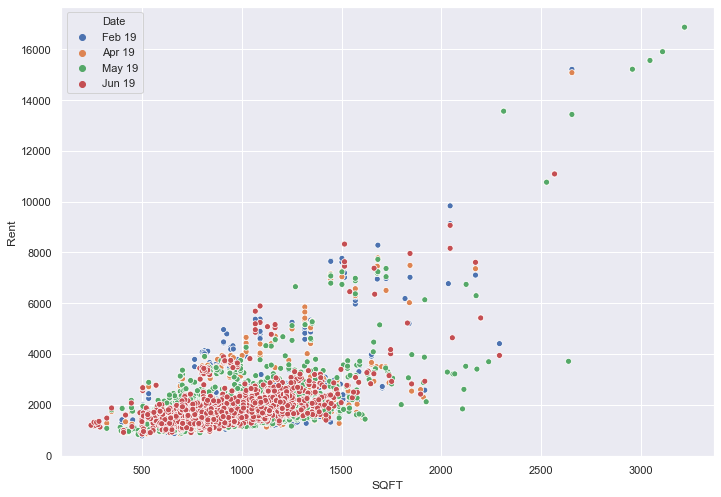

In [130]:
# Assumption: more sqft means higher rent
sb.scatterplot(x="SQFT", y="Rent", hue="Date", data=master_df)
plt.show()


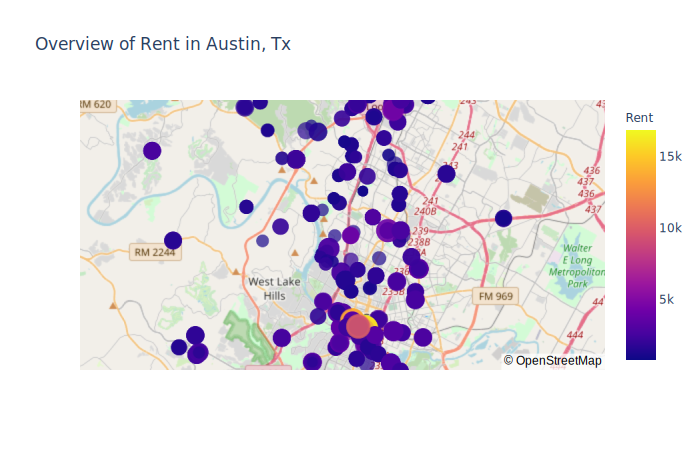

In [131]:
## Plot Map with Data
fig = px.scatter_mapbox(master_df, lat="latitude", lon="longitude", hover_name="Title",
                        hover_data=["Beds", "Baths", "Rent", "SQFT"], color="Rent", size="SQFT",
                        color_discrete_sequence=px.colors.diverging.balance, size_max=20, zoom=10, height=600,
                        title="Overview of Rent in Austin, Tx")
fig.update_layout(mapbox_style='open-street-map')
fig.show(renderer='svg')

In [132]:
# Examine One Bedroom listings
one_beds = master_df[master_df["Beds"] == 1].copy()

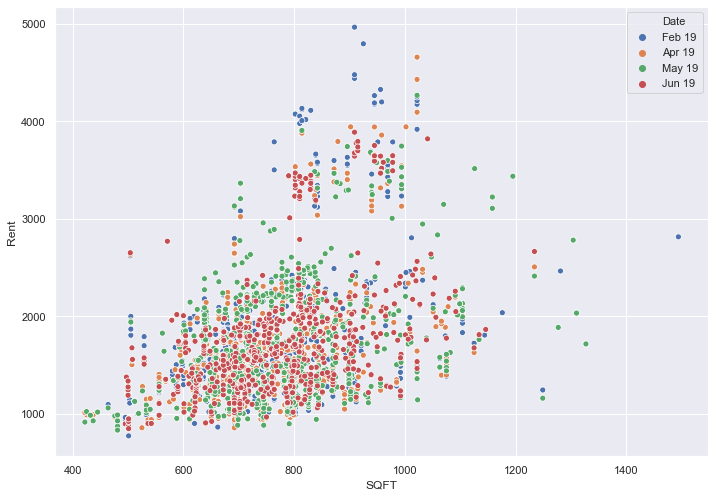

In [133]:

sb.scatterplot(x="SQFT", y="Rent", hue="Date", data=one_beds)
plt.show()

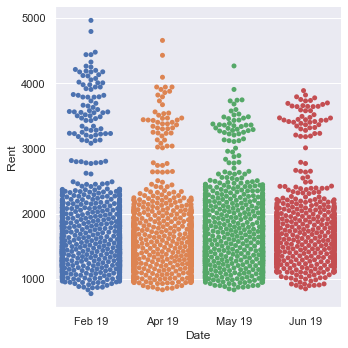

In [134]:

sb.catplot(x="Date", y="Rent",
            kind="swarm", data=one_beds);

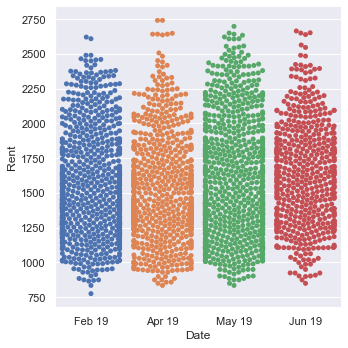

In [135]:

# Cut out extreme cases
sb.catplot(x="Date", y="Rent",
            kind="swarm", data=one_beds[one_beds["Rent"] < 2750]);

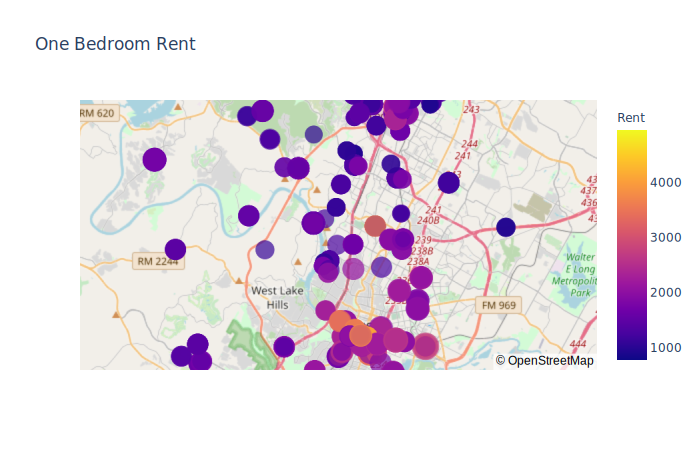

In [136]:
## Plot Map with Data
fig = px.scatter_mapbox(one_beds, lat="latitude", lon="longitude", hover_name="Title",
                        hover_data=["Beds", "Baths", "Rent"], color="Rent", size="SQFT",
                        color_discrete_sequence=px.colors.diverging.balance, size_max=20, zoom=10, height=600,
                        title="One Bedroom Rent")
fig.update_layout(mapbox_style='open-street-map')
fig.show(renderer='svg')

In [137]:
avg_sqft = one_beds["SQFT"].mean()
avg_sqft

774.6699393358876

In [138]:
avg_rent = one_beds["Rent"].mean()
avg_rent

1716.555871773176

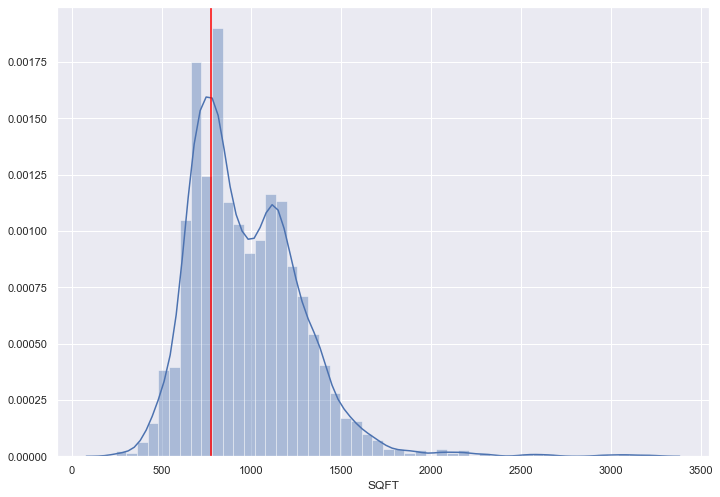

In [139]:

sb.distplot(master_df["SQFT"])
plt.axvline(avg_sqft, color="red")

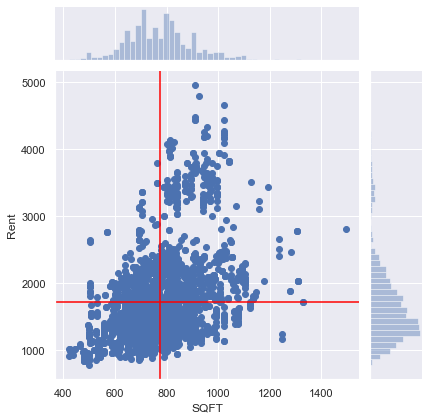

In [140]:

scat = sb.jointplot(x="SQFT", y="Rent", data=one_beds);
scat.ax_joint.axvline(avg_sqft, color="red")
scat.ax_joint.axhline(avg_rent, color="red")

In [141]:
# creates 10 clusters using hierarchical clustering.
agc = AgglomerativeClustering(n_clusters =10, affinity='euclidean', linkage='ward')
master_df['cluster'] = agc.fit_predict(master_df[['latitude','longitude']])

# creates 10 clusters using k-means clustering algorithm.
# kmeans = KMeans(10)
# clusters = kmeans.fit_predict(test[['latitude','longitude']])
# master_df['cluster'] = kmeans.predict(test[['latitude','longitude']])

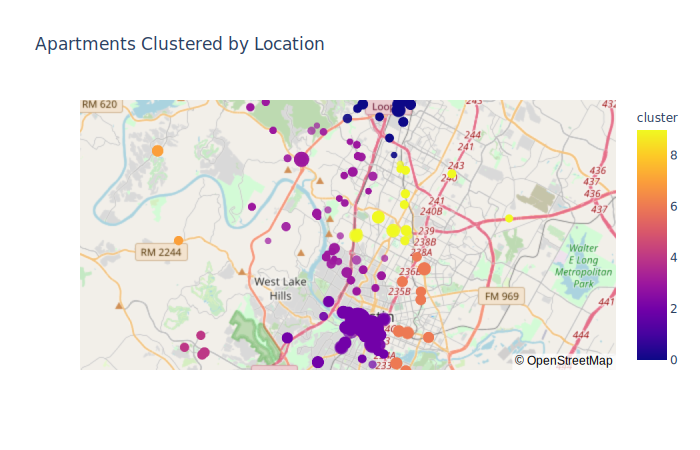

In [142]:
fig = px.scatter_mapbox(master_df, lat="latitude", lon="longitude", hover_name="Title",
                        hover_data=["Beds", "Baths", "Rent", "SQFT"], color="cluster", size="Rent",
                        size_max=20, zoom=10, height=600,
                        title="Apartments Clustered by Location")
fig.update_layout(mapbox_style='open-street-map', showlegend=True)
fig.show(renderer='svg')

In [143]:
mode = lambda x:x.value_counts().index[0]
agg_rule = {"Rent" : ["mean", "median", "min", "max", mode], 
            "SQFT" : ["mean", "median", "min", "max", mode],
            "Beds": ["median", "min", "max", mode,"count"]}
new_cols = ["Rent Mean", "Rent Median", "Rent Min", "Rent Max", "Rent Mode",
           "SQFT Mean", "SQFT Median", "SQFT Min", "SQFT Max", "SQFT Mode",
           "Beds Median", "Beds Min", "Beds Max", "Beds Mode", "Count"]
overall_summary = master_df.copy().groupby("cluster")[["Rent", "SQFT", "Beds"]].agg(agg_rule).round(2)
overall_summary.columns = overall_summary.columns.droplevel(0)
overall_summary.columns = new_cols
# overall_summary.reset_index(inplace=True)


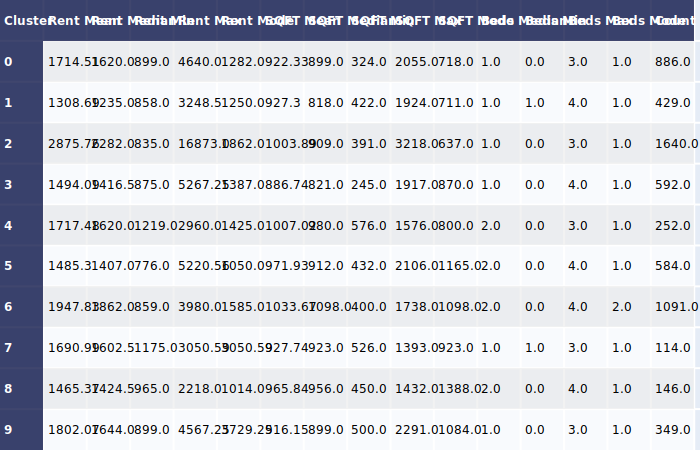

In [144]:
## Overall Summary Table

fig = ff.create_table(overall_summary, index=True, index_title="Cluster")
fig.layout.width = 1500
fig.show(renderer='svg')

In [145]:
# Examine 1-Bedroom Listings
agg_rule = {"Rent" : ["mean", "median", "min", "max", mode], 
            "SQFT" : ["mean", "median", "min", "max", mode, "count"]}
new_cols = ["Rent Mean", "Rent Median", "Rent Min", "Rent Max", "Rent Mode",
           "SQFT Mean", "SQFT Median", "SQFT Min", "SQFT Max", "SQFT Mode", "Count"]
onebd_summary = master_df[master_df["Beds"] == 1].groupby("cluster")[["Rent", "SQFT"]].agg(agg_rule).round(2)
onebd_summary.columns = onebd_summary.columns.droplevel(0)
onebd_summary.columns = new_cols

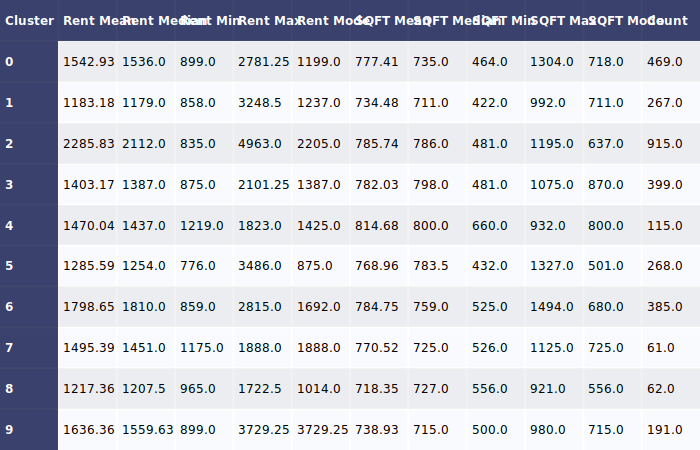

In [146]:
## One Bedroom Summary Table
fig = ff.create_table(onebd_summary, index=True, index_title="Cluster")
fig.layout.width = 1500
fig.show(renderer='svg')

In [147]:
# normalize features
pt = preprocessing.PowerTransformer(standardize=False)
ml_df = master_df.select_dtypes(include=[np.number]).copy()
y = ml_df["Rent"]
X = ml_df.drop(labels=["latitude","longitude", "Rent"], axis=1)
X_tran = pt.fit_transform(X)

C:\Users\xrchr\Miniconda3\envs\aptEnv\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning:

divide by zero encountered in log



In [148]:
clf = ET.ml_alg(X_tran, y)

In [149]:
# 1-bed, 1-bath, average sq-ft, cluster-0
x_predict = pt.transform(np.array([1, 1, avg_sqft, 6]).reshape(1, -1))
x_predict

array([[0.81832025, 0.35589166, 0.09808594, 3.00130563]])

In [150]:
clf.predict(x_predict).round(2)


array([1550.02])

In [151]:
rent_by_area = dict()
for i in range(0,10):
    x_pred = pt.transform(np.array([1, 1, avg_sqft, i]).reshape(1, -1))
    rent_by_area[i] = clf.predict(x_pred).round(2)
rent_by_area

{0: array([1845.43]),
 1: array([1766.32]),
 2: array([1708.25]),
 3: array([1660.66]),
 4: array([1619.61]),
 5: array([1583.12]),
 6: array([1550.02]),
 7: array([1519.57]),
 8: array([1491.28]),
 9: array([1464.76])}